# **Working memory training**: DMN, FPN rectuitment and integration stats

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 04-10-2018

Step 0: Setup
------------------

In [9]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1)



Step 1: Loading data
------------------

In [12]:
setwd("~/Dropbox/Projects/LearningBrain/")
fc_cartography = read.csv('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/Power_integration_recruitment_all_networks.csv')

dualnback_exclude = c('sub-13', 'sub-21', 'sub-23', 'sub-50') # higly motion subjects in one of four sessions

fc_cartography$Session <- factor(fc_cartography$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))
fc_cartography_clean <- fc_cartography %>% filter(!(Subject %in% dualnback_exclude))

dmn <- fc_cartography_clean %>% filter(Network == 'DM')
fpn <- fc_cartography_clean %>% filter(Network == 'FP')

Step 2: Multilevel modeling (FP recruitmnent)
--------------------------------

In [13]:
baseline <- lme(FP ~ 1, random = ~ 1 |Subject/Session, data = fpn, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
session <- update(baseline, .~. + Session)
group <- update(session, .~. + Group)
session_group <- update(group, .~. + Session:Group)

anova(baseline, session, group, session_group)

call                                                                                                                                                              
baseline      lme.formula(fixed = FP ~ 1, data = fpn, random = ~1 | Subject/Session,     method = "ML", control = lmeControl(returnObject = TRUE))                              
session       lme.formula(fixed = FP ~ Session, data = fpn, random = ~1 | Subject/Session,     method = "ML", control = lmeControl(returnObject = TRUE))                        
group         lme.formula(fixed = FP ~ Session + Group, data = fpn, random = ~1 |     Subject/Session, method = "ML", control = lmeControl(returnObject = TRUE))                
session_group lme.formula(fixed = FP ~ Session + Group + Session:Group, data = fpn,     random = ~1 | Subject/Session, method = "ML", control = lmeControl(returnObject = TRUE))
              Model df AIC       BIC       logLik   Test   L.Ratio  
baseline      1      4 -571.3567 -558.8608 289.6784               NA
session       2      7 -580.5992 -558.7314 297.2996 1 vs 2 15.242478
group         3      8 -586.4747 -561.4829 301.2373 2 vs 3  7.875472
session_group 4     11 -592.3732 -558.0096 307.1866 3 vs 4 11.898588
              p-value    
baseline               NA
session       0.001620733
group         0.005010979
session_group 0.007738753

In [23]:
summary(session_group)

Linear mixed-effects model fit by maximum likelihood
 Data: fpn 
        AIC       BIC   logLik
  -592.3732 -558.0096 307.1866

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:  0.03112223

 Formula: ~1 | Session %in% Subject
        (Intercept)   Residual
StdDev:  0.02928741 0.01278855

Fixed effects: FP ~ Session + Group + Session:Group 
                                     Value   Std.Error  DF  t-value p-value
(Intercept)                      0.3963369 0.009974699 120 39.73422  0.0000
SessionEarly                     0.0287134 0.010105935 120  2.84124  0.0053
SessionMiddle                    0.0191702 0.010105935 120  1.89693  0.0602
SessionLate                      0.0165277 0.010105935 120  1.63544  0.1046
GroupExperimental                0.0313186 0.014106355  40  2.22018  0.0321
SessionEarly:GroupExperimental  -0.0252669 0.014291951 120 -1.76791  0.0796
SessionMiddle:GroupExperimental  0.0033234 0.014291951 120  0.23254  0.8165
SessionLate:GroupExperimental   

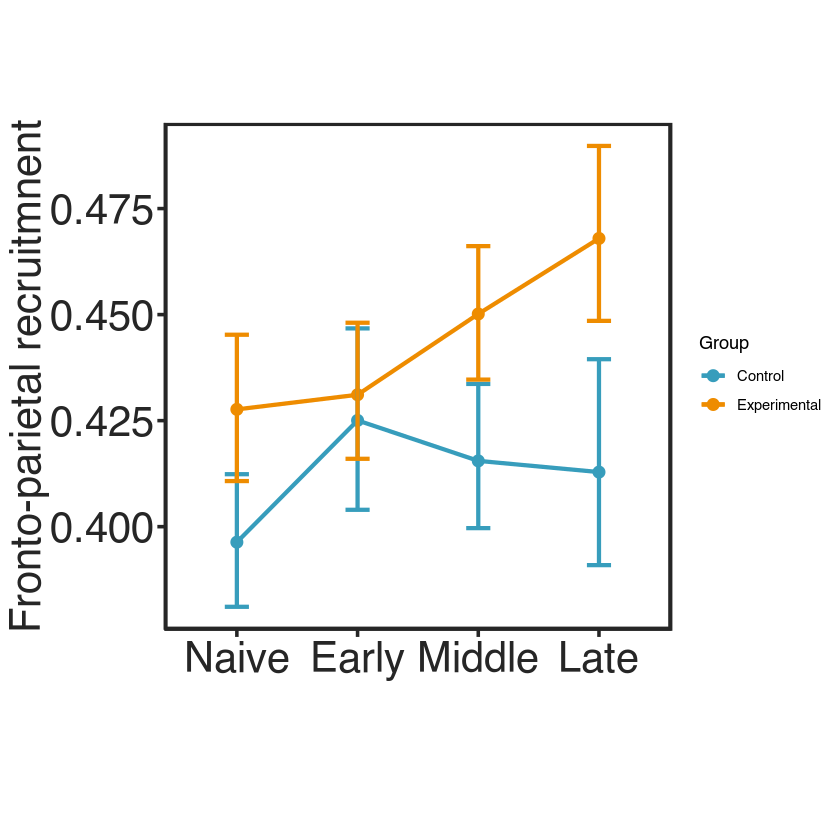

In [27]:
p <- ggplot(fpn, aes(x = Session, y = FP, col = Group)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    ylab('Fronto-parietal recruitmnent') +
    #facet_wrap(~Group) +
    xlab(' ') +
    theme_training
p

ggsave("figures/Figure_FP_recr.pdf", plot = p, width = 6, height = 6, dpi = 300)  

In [15]:
fpn %>% 
    group_by(Session, Group) %>% filter(Session %in% c('Naive', 'Late'))%>%
    summarize(mFP = mean(FP))

Session Group        mFP      
1 Naive   Control      0.3963369
2 Naive   Experimental 0.4276555
3 Late    Control      0.4128646
4 Late    Experimental 0.4679554

In [16]:
fpn_nl <- fpn %>% filter(Session %in% c('Naive', 'Late'))

fpn_exp <-  fpn_nl %>% filter(Group == 'Experimental') 
fpn_con <-  fpn_nl %>% filter(Group == 'Control') 

t.test(fpn_exp$FP ~ fpn_exp$Session, paired = TRUE)
t.test(fpn_con$FP ~ fpn_con$Session, paired = TRUE)


	Paired t-test

data:  fpn_exp$FP by fpn_exp$Session
t = -3.5157, df = 20, p-value = 0.002175
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06421111 -0.01638866
sample estimates:
mean of the differences 
            -0.04029989 



	Paired t-test

data:  fpn_con$FP by fpn_con$Session
t = -1.6887, df = 20, p-value = 0.1068
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03694319  0.00388780
sample estimates:
mean of the differences 
             -0.0165277 


Step 3: Multilevel modeling (DM recruitmnent)
--------------------------------

In [11]:
baseline <- lme(DM ~ 1, random = ~ 1 |Subject/Session, data = dmn, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
session <- update(baseline, .~. + Session)
group <- update(session, .~. + Group)
session_group <- update(group, .~. + Session:Group)


anova(baseline, session, group, session_group) 

call                                                                                                                                                              
baseline      lme.formula(fixed = DM ~ 1, data = dmn, random = ~1 | Subject/Session,     method = "ML", control = lmeControl(returnObject = TRUE))                              
session       lme.formula(fixed = DM ~ Session, data = dmn, random = ~1 | Subject/Session,     method = "ML", control = lmeControl(returnObject = TRUE))                        
group         lme.formula(fixed = DM ~ Session + Group, data = dmn, random = ~1 |     Subject/Session, method = "ML", control = lmeControl(returnObject = TRUE))                
session_group lme.formula(fixed = DM ~ Session + Group + Session:Group, data = dmn,     random = ~1 | Subject/Session, method = "ML", control = lmeControl(returnObject = TRUE))
              Model df AIC       BIC       logLik   Test   L.Ratio  
baseline      1      4 -572.9167 -560.4209 290.4584               NA
session       2      7 -595.0112 -573.1434 304.5056 1 vs 2 28.094449
group         3      8 -597.2368 -572.2451 306.6184 2 vs 3  4.225648
session_group 4     11 -595.7550 -561.3914 308.8775 3 vs 4  4.518187
              p-value     
baseline                NA
session       3.469963e-06
group         3.981742e-02
session_group 2.106737e-01

In [17]:
summary(session)

Linear mixed-effects model fit by maximum likelihood
 Data: fpn 
        AIC       BIC   logLik
  -580.5992 -558.7314 297.2996

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:  0.03457936

 Formula: ~1 | Session %in% Subject
        (Intercept)   Residual
StdDev:  0.03063129 0.01357088

Fixed effects: FP ~ Session 
                  Value   Std.Error  DF  t-value p-value
(Intercept)   0.4119962 0.007519368 123 54.79133  0.0000
SessionEarly  0.0160799 0.007399553 123  2.17309  0.0317
SessionMiddle 0.0208319 0.007399553 123  2.81529  0.0057
SessionLate   0.0284138 0.007399553 123  3.83993  0.0002
 Correlation: 
              (Intr) SssnEr SssnMd
SessionEarly  -0.492              
SessionMiddle -0.492  0.500       
SessionLate   -0.492  0.500  0.500

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-0.81047518 -0.27253386 -0.06676332  0.26882409  0.92495032 

Number of Observations: 168
Number of Groups: 
             Sub

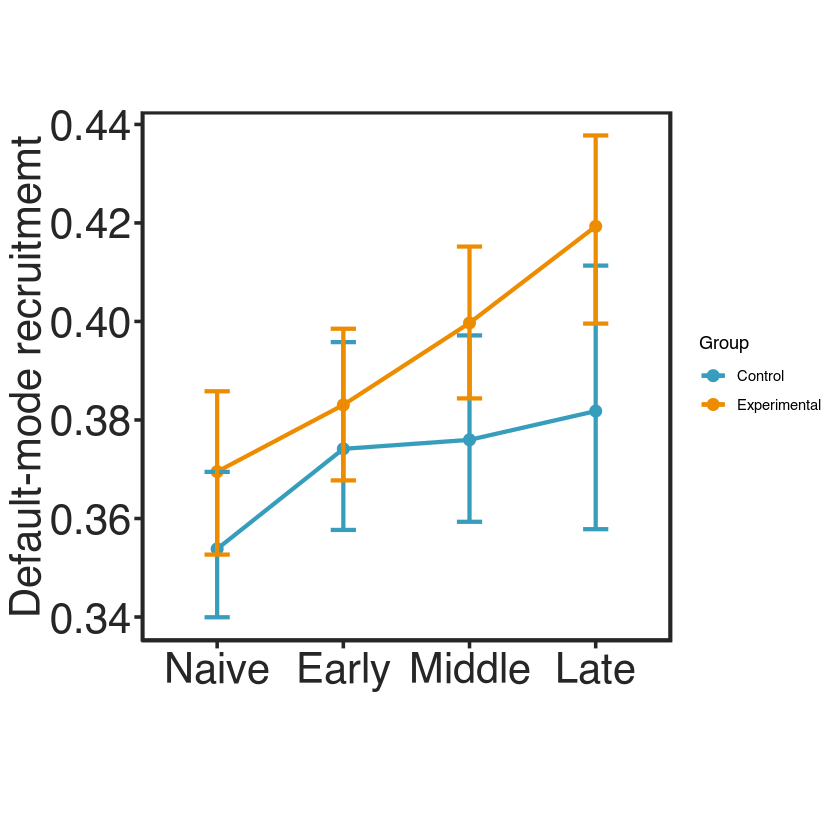

In [28]:
p <- ggplot(dmn, aes(x = Session, y = DM, col = Group)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    ylab('Default-mode recruitmemt') +
    xlab(' ') +
    theme_training
p

ggsave("figures/Figure_DM_recr.pdf", plot = p, width = 6, height = 6, dpi = 300)  

In [13]:
dmn_nl <- dmn %>% filter(Session %in% c('Naive', 'Late'))

dmn_exp <-  dmn_nl %>% filter(Group == 'Experimental') 
dmn_con <-  dmn_nl %>% filter(Group == 'Control') 

t.test(dmn_exp$DM ~ fpn_exp$Session, paired = TRUE)
t.test(dmn_con$DM ~ fpn_con$Session, paired = TRUE)


	Paired t-test

data:  dmn_exp$DM by fpn_exp$Session
t = -4.6698, df = 20, p-value = 0.0001474
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07204050 -0.02755267
sample estimates:
mean of the differences 
            -0.04979659 



	Paired t-test

data:  dmn_con$DM by fpn_con$Session
t = -2.9269, df = 20, p-value = 0.008337
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04792828 -0.00804021
sample estimates:
mean of the differences 
            -0.02798424 


In [14]:
dmn %>% 
    group_by(Session, Group) %>% filter(Session %in% c('Naive', 'Late'))%>%
    summarize(mDM = mean(DM))
    

Session Group        mDM      
1 Naive   Control      0.3538219
2 Naive   Experimental 0.3695092
3 Late    Control      0.3818061
4 Late    Experimental 0.4193058

Step 4: Multilevel modeling (FP-DM integration)
-----------------------------

In [16]:
baseline <- lme(FP ~ 1, random = ~ 1 |Subject/Session, data = dmn, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
session <- update(baseline, .~. + Session)
group <- update(session, .~. + Group)
session_group <- update(group, .~. + Session:Group)


anova(baseline, session, group, session_group) 

call                                                                                                                                                              
baseline      lme.formula(fixed = FP ~ 1, data = dmn, random = ~1 | Subject/Session,     method = "ML", control = lmeControl(returnObject = TRUE))                              
session       lme.formula(fixed = FP ~ Session, data = dmn, random = ~1 | Subject/Session,     method = "ML", control = lmeControl(returnObject = TRUE))                        
group         lme.formula(fixed = FP ~ Session + Group, data = dmn, random = ~1 |     Subject/Session, method = "ML", control = lmeControl(returnObject = TRUE))                
session_group lme.formula(fixed = FP ~ Session + Group + Session:Group, data = dmn,     random = ~1 | Subject/Session, method = "ML", control = lmeControl(returnObject = TRUE))
              Model df AIC       BIC       logLik   Test   L.Ratio   
baseline      1      4 -830.4217 -817.9258 419.2108                NA
session       2      7 -834.1625 -812.2947 424.0812 1 vs 2 9.74076797
group         3      8 -832.1999 -807.2082 424.1000 2 vs 3 0.03743757
session_group 4     11 -832.8025 -798.4388 427.4012 3 vs 4 6.60254786
              p-value   
baseline              NA
session       0.02090324
group         0.84657688
session_group 0.08570483

In [20]:
summary(session)

Linear mixed-effects model fit by maximum likelihood
 Data: dmn 
        AIC       BIC   logLik
  -834.1625 -812.2947 424.0812

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:  0.01693587

 Formula: ~1 | Session %in% Subject
        (Intercept)   Residual
StdDev:  0.01422053 0.00638405

Fixed effects: FP ~ Session 
                    Value   Std.Error  DF  t-value p-value
(Intercept)    0.26838011 0.003594723 123 74.65947  0.0000
SessionEarly   0.00152752 0.003442770 123  0.44369  0.6580
SessionMiddle  0.00192351 0.003442770 123  0.55871  0.5774
SessionLate   -0.00753103 0.003442770 123 -2.18749  0.0306
 Correlation: 
              (Intr) SssnEr SssnMd
SessionEarly  -0.479              
SessionMiddle -0.479  0.500       
SessionLate   -0.479  0.500  0.500

Standardized Within-Group Residuals:
         Min           Q1          Med           Q3          Max 
-0.911753182 -0.255647686  0.009800037  0.258696365  1.114260780 

Number of Observations: 168
Number of Group

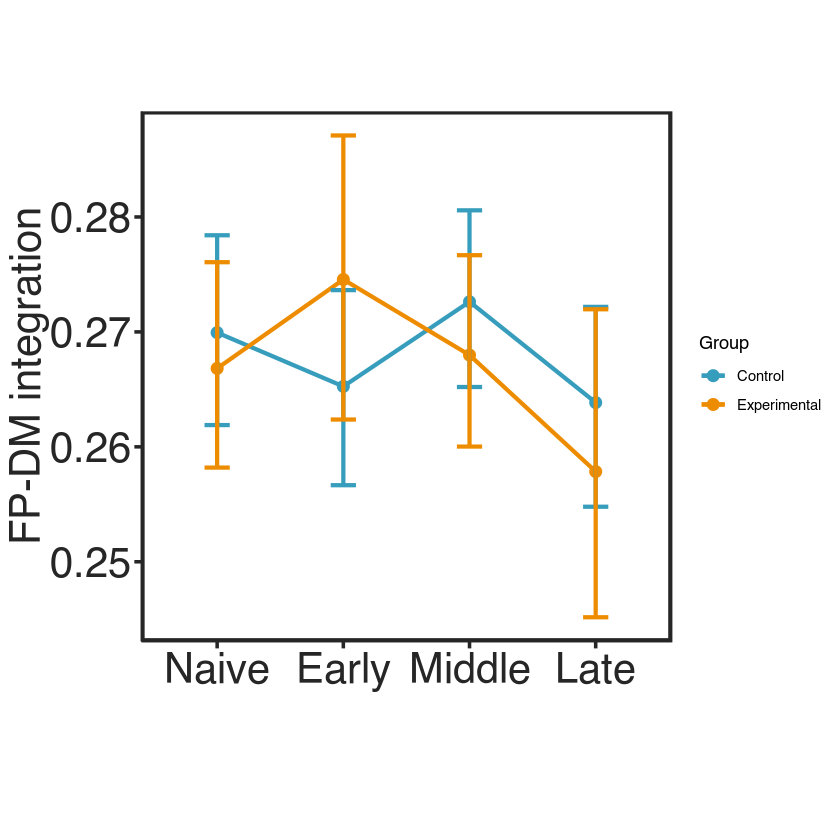

In [29]:
p <- ggplot(dmn, aes(x = Session, y = FP, col = Group)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    ylab('FP-DM integration') +
    #facet_wrap(~Group) +
    xlab(' ') +
    theme_training
p

ggsave("figures/Figure_FPN-DMN_integ.pdf", plot = p, width = 6, height = 6, dpi = 300)  

In [19]:
dmn_nl <- dmn %>% filter(Session %in% c('Naive', 'Late'))

dmn_exp <-  dmn_nl %>% filter(Group == 'Experimental') 
dmn_con <-  dmn_nl %>% filter(Group == 'Control') 

t.test(dmn_exp$FP ~ fpn_exp$Session, paired = TRUE)
t.test(dmn_con$FP ~ fpn_con$Session, paired = TRUE)


	Paired t-test

data:  dmn_exp$FP by fpn_exp$Session
t = 1.3696, df = 20, p-value = 0.186
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.004694979  0.022648411
sample estimates:
mean of the differences 
            0.008976716 



	Paired t-test

data:  dmn_con$FP by fpn_con$Session
t = 1.4838, df = 20, p-value = 0.1534
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.002469454  0.014640160
sample estimates:
mean of the differences 
            0.006085353 
